In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Hyperspectral Image Datasets/Datasets/

/content/drive/MyDrive/Colab Notebooks/Hyperspectral Image Datasets/Data


# Import Libraries

In [ ]:
!pip install earthpy

In [ ]:
!pip install tensorflow_addons

In [ ]:
!pip install spectral

In [6]:
import sys
# Append the directory to your python path using sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Project_Path')
# Import the module
import SWIN_Transformer_Model

In [8]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, MaxPooling2D, Dropout, Flatten, Conv2D, Conv3D, LeakyReLU, Reshape
from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers
from keras.models import Model
from tensorflow.python.keras.utils import np_utils
import tensorflow_addons as tfa


from tqdm import tqdm
from numpy.random import seed
from time import time

from SWIN_Transformer_Model import PatchMerging, PatchExtract, PatchEmbedding, SwinTransformer
from operator import truediv
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA

import os

seed(11)

# Load Data

In [9]:
################## X data (610, 340, 103)   Hyperspectral satellite   (610*340, 103)
data = loadmat('PU/PaviaU.mat')['paviaU']


###################### Y data (labels)
gt = loadmat('PU/PaviaU_gt.mat')['paviaU_gt']

print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shape: (610, 340)
Number of Bands: 103


In [ ]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

In [ ]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


In [ ]:
df

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207395,574,594,504,411,468,443,378,342,352,434,...,2150,2157,2157,2169,2151,2108,2077,2076,2136,0
207396,485,644,709,582,504,494,434,373,391,421,...,2264,2295,2282,2265,2275,2293,2274,2274,2258,0
207397,593,387,428,461,470,392,331,383,439,355,...,2393,2407,2433,2413,2373,2389,2382,2407,2423,0
207398,593,751,655,458,503,560,482,412,404,454,...,2340,2333,2332,2288,2251,2280,2312,2308,2289,0


In [ ]:
df['class'].unique()

array([0, 1, 4, 2, 8, 5, 9, 6, 3, 7], dtype=uint8)

# Data Visualization

In [ ]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# RGB Composite Image

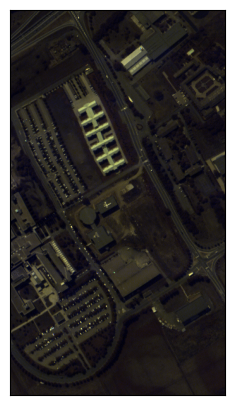

In [ ]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (29, 23, 0), figsize=(5, 5))

plt.show()

# GroundTruth Visualizaation

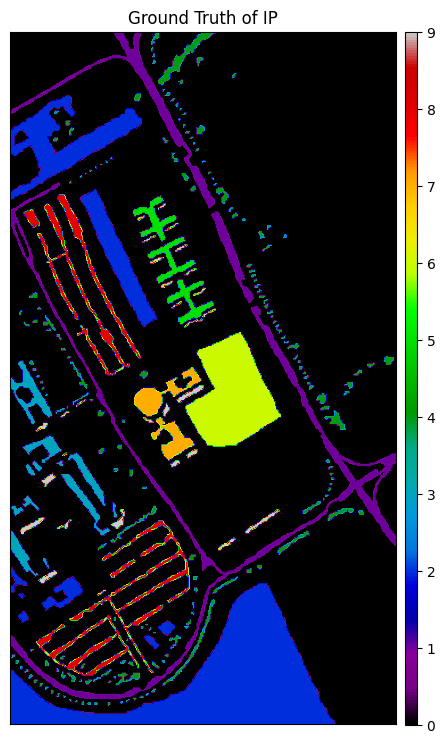

In [ ]:
ep.plot_bands(gt, cmap='nipy_spectral', title='Ground Truth of IP', figsize=(7, 9))
plt.show()

# Data Preparation

In [10]:
## GLOBAL VARIABLES

# Proportion of the sample used for testing
test_ratio = 0.7
# Proportion of the sample used for Validation
val_ratio = 0.1
# Size of the extracted patch around each pixel
patch1_size = 25
# Number of principal components obtained by dimensionality reduction using PCA (original data: 30)
pca_components = 30
# classes
num_classes = 9
dataset='PU'

In [11]:
# Apply PCA transform to hyperspectral data X
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

In [12]:
# When extracting the patch around a single pixel, the edge pixels cannot be taken, so a padding operation is applied to this part of the pixel (margin original is 2)
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [13]:
# Extract the patch around each pixel and create it in a format that matches the keras processing (originally windowSize=5)
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    # for X to padding
    margin = int((windowSize ) / 2)  # hybirdcnn是（（windowsize-1）/2）
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [14]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [15]:
print('Hyperspectral data shape: ', data.shape)
print('Label shape: ', gt.shape)

Hyperspectral data shape:  (610, 340, 103)
Label shape:  (610, 340)


In [16]:
print('\n... ... PCA tranformation ... ...')
X = applyPCA(data, numComponents=pca_components)
print('Data shape after PCA: ', X.shape)


... ... PCA tranformation ... ...
Data shape after PCA:  (610, 340, 30)


In [17]:
#X, Y = createImageCubes(data, gt, windowSize=windowSize, removeZeroLabels = True)
#X.shape, Y.shape

print('\n... ... create data cubes ... ...')
X, Y = createImageCubes(X, gt, windowSize=patch1_size)
print('Data cube X shape: ', X.shape)
print('Data cube y shape: ', Y.shape)


... ... create data cubes ... ...
Data cube X shape:  (42776, 25, 25, 30)
Data cube y shape:  (42776,)


In [18]:
# Reshape The X because we used 3D
#(n, W, H, B)
#(n, W, H, B, 1)
X = X.reshape((X.shape[0],patch1_size,patch1_size,30,1))
X.shape

(42776, 25, 25, 30, 1)

# Split Data

In [19]:
print('\n... ... create train & val & test data ... ...')
X_train, X_test, y_train, y_test = splitTrainTestSet(X, Y, test_ratio)
X_train, X_val, y_train, y_val = splitTrainTestSet(X_train, y_train, val_ratio)

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('X_test  shape: ', X_test.shape)
print('y_train shape: ',y_train.shape)
print('y_val shape: ',y_val.shape)
print('y_test shape:' , y_test.shape)


... ... create train & val & test data ... ...
X_train shape:  (11548, 25, 25, 30, 1)
X_val shape:  (1284, 25, 25, 30, 1)
X_test  shape:  (29944, 25, 25, 30, 1)
y_train shape:  (11548,)
y_val shape:  (1284,)
y_test shape: (29944,)


In [20]:
# Change the shape of y_train, y_val and  to match keras
y_train=np_utils.to_categorical(y_train)
y_val=np_utils.to_categorical(y_val)
y_test=np_utils.to_categorical(y_test)

print('y_train shape: ',y_train.shape)
print('y_val shape: ',y_val.shape)
print('y_test shape:' , y_test.shape)

y_train shape:  (11548, 9)
y_val shape:  (1284, 9)
y_test shape: (29944, 9)


# Parameters and Functions

In [21]:
#input_shape = (25, 25, 30) #need to follow loading.shape and afterPCA ---> ip_shape
input_shape = (25, 25, 30, 1)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate (origin0.03)
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension (origin64)
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 25  # Initial image size (origin32) （afterPCA25）（afterCNN module 17）

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 512
#num_epochs = 10
num_epochs = 1
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

# Build Model

In [22]:
imIn = Input(shape=input_shape)
imIn

<KerasTensor: shape=(None, 25, 25, 30, 1) dtype=float32 (created by layer 'input_1')>

In [25]:
# CNN Model
## 3D Convolutional Layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(imIn)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
print("---------------------------")
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
print(conv_layer3.shape)
print("---------------------------")

#2DCNN
conv_layer4 =Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
print(conv_layer4.shape)
print("---------------------------")

# SWIN Transformer Layers
x = layers.RandomCrop(image_dimension, image_dimension)(conv_layer4)
print('random crop:',x.shape)
x = layers.RandomFlip("horizontal")(x)
print('random flip:',x.shape)
x = PatchExtract(patch_size)(x)
print('patch extract:',x.shape)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
print('patch embedding:',x.shape)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
print('swin1:',x.shape)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
print('swin2:',x.shape)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
print('patchmerging:',x.shape)
x = layers.GlobalAveragePooling1D()(x)
print('global average pooling:',x.shape)
output = layers.Dense(num_classes, activation="softmax")(x)
print('out:',x.shape)

(None, 19, 19, 18, 32)
---------------------------
(None, 19, 19, 576)
---------------------------
(None, 17, 17, 64)
---------------------------
random crop: (None, 25, 25, 64)
random flip: (None, 25, 25, 64)
patch extract: (None, 144, 256)
patch embedding: (None, 144, 64)
swin1: (None, 144, 64)
swin2: (None, 144, 64)
patchmerging: (None, 36, 128)
global average pooling: (None, 128)
out: (None, 128)


In [26]:
model = Model(inputs=[imIn], outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d_3 (Conv3D)           (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_4 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_5 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape_1 (Reshape)         (None, 19, 19, 576)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        331840    
                                                                 
 random_crop_1 (RandomCrop)  (None, 25, 25, 64)        0   

## Train Model

In [27]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

In [28]:
start = time()

history = model.fit(
    X_train, #The display is modified: the original indicates x_train, y_train
    y_train, #
    batch_size=batch_size,
    epochs=100,
    validation_data = (X_val, y_val),
)

end = time()
print("\n Training Time:", (end-start))

# Save Training Hostry to CSV
history_data = pd.DataFrame(history.history)
history_data_csv_file = '/content/drive/MyDrive/Colab Notebooks/Save_Files/PU/PU_history.csv'
with open(history_data_csv_file, mode='w') as f:
    history_data.to_csv(f)

Epoch 1/100
23/23 [==============================] - 20s 365ms/step - loss: 2.6493 - accuracy: 0.3108 - val_loss: 1.9245 - val_accuracy: 0.4283
Epoch 2/100
23/23 [==============================] - 4s 191ms/step - loss: 1.6508 - accuracy: 0.4813 - val_loss: 1.2929 - val_accuracy: 0.6254
Epoch 3/100
23/23 [==============================] - 4s 191ms/step - loss: 1.0762 - accuracy: 0.7350 - val_loss: 0.8957 - val_accuracy: 0.8310
Epoch 4/100
23/23 [==============================] - 4s 191ms/step - loss: 0.8058 - accuracy: 0.8886 - val_loss: 0.7341 - val_accuracy: 0.9221
Epoch 5/100
23/23 [==============================] - 4s 191ms/step - loss: 0.6884 - accuracy: 0.9429 - val_loss: 0.6519 - val_accuracy: 0.9587
Epoch 6/100
23/23 [==============================] - 4s 190ms/step - loss: 0.6269 - accuracy: 0.9652 - val_loss: 0.6045 - val_accuracy: 0.9798
Epoch 7/100
23/23 [==============================] - 4s 190ms/step - loss: 0.5899 - accuracy: 0.9776 - val_loss: 0.5866 - val_accuracy: 0.986

## Result

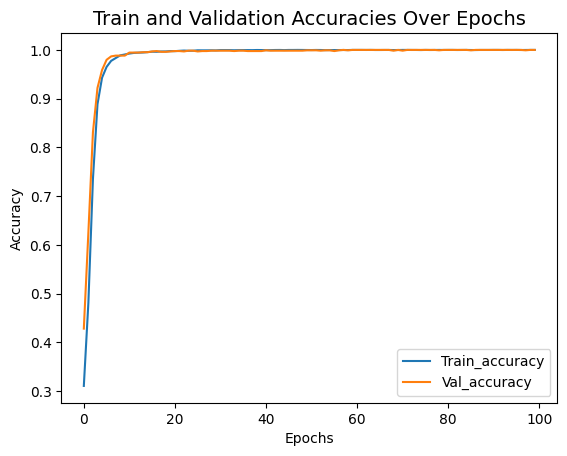

In [29]:
plt.plot(history.history["accuracy"], label="Train_accuracy")
plt.plot(history.history["val_accuracy"], label="Val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracies Over Epochs", fontsize=14)
plt.legend()
#plt.grid()
plt.show()

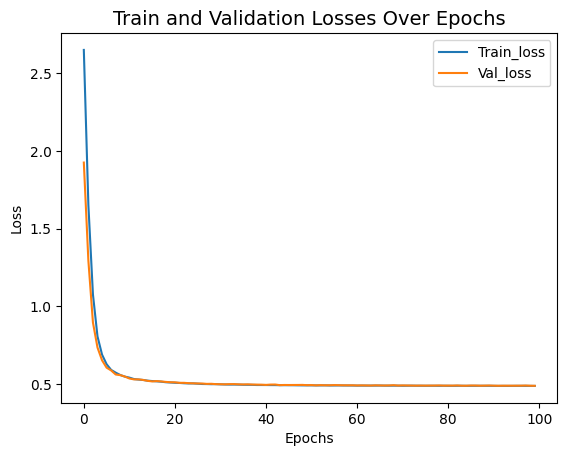

In [30]:
plt.plot(history.history["loss"], label="Train_loss")
plt.plot(history.history["val_loss"], label="Val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
#plt.grid()
plt.show()

In [31]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

936/936 [==============================] - 10s 10ms/step - loss: 0.4882 - accuracy: 0.9997
Test loss: 0.49
Test accuracy: 99.97%


In [32]:
Y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(y_test, axis=1), y_pred_test)
print(classification)

936/936 [==============================] - 10s 10ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4642
           1       1.00      1.00      1.00     13055
           2       1.00      1.00      1.00      1469
           3       1.00      1.00      1.00      2145
           4       1.00      1.00      1.00       942
           5       1.00      1.00      1.00      3520
           6       1.00      1.00      1.00       931
           7       1.00      1.00      1.00      2577
           8       1.00      1.00      1.00       663

    accuracy                           1.00     29944
   macro avg       1.00      1.00      1.00     29944
weighted avg       1.00      1.00      1.00     29944



## Classification Map

In [33]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [34]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [35]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test,y_test,dataset)
classification = str(classification)
confusion = str(confusion)
print(classification)
file_name = "/content/drive/MyDrive/Colab Notebooks/Save_Files/PU/PU_classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

936/936 [==============================] - 10s 10ms/step - loss: 0.4883 - accuracy: 0.9996
                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      4642
             Meadows       1.00      1.00      1.00     13055
              Gravel       1.00      1.00      1.00      1469
               Trees       1.00      1.00      1.00      2145
Painted metal sheets       1.00      1.00      1.00       942
           Bare Soil       1.00      1.00      1.00      3520
             Bitumen       1.00      1.00      1.00       931
Self-Blocking Bricks       1.00      1.00      1.00      2577
             Shadows       1.00      1.00      1.00       663

            accuracy                           1.00     29944
           macro avg       1.00      1.00      1.00     29944
        weighted avg       1.00      1.00      1.00     29944



# Show predicted image

In [40]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

# K after PCA
K = 30
windowSize1 = 25

In [41]:
X = loadmat('PU/PaviaU.mat')['paviaU']
y = loadmat('PU/PaviaU_gt.mat')['paviaU_gt']

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize1
numComponents = K

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, PATCH_SIZE//2)

# calculate the predicted image
outputs = np.zeros((height,width))
for i in tqdm(range(height)):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2],1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1



Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


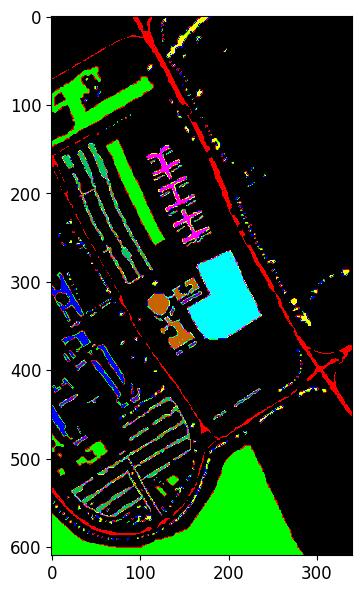

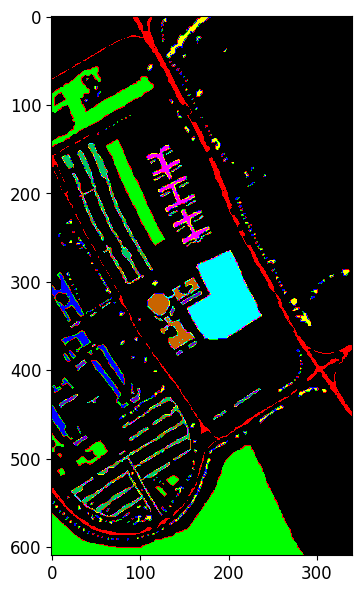

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/Save_Files/PU/PU_predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/Save_Files/PU/PU_ground_truth.png", y, colors=spectral.spy_colors)